In [3]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [6]:
w, h = 304,304
border = 5 

In [7]:
ids = next(os.walk("/content/800_dataset_with_semantic_segmentation/train_images/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  61


# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import glob
train = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_images/*"))
train_mask = sorted(glob.glob("/content/800_dataset_with_semantic_segmentation/train_segmentation/*.png"))[:64]
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 61
Total Mask Image : 61


In [10]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [11]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

In [12]:
# Save the files in Numpy array for reusability
np.save('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/X.npy', X)
np.save('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/X.npy')
y = np.load('/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/XandY/y.npy')
print(X.shape, y.shape)

(61, 304, 304, 3) (61, 304, 304, 1)


In [13]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(54, 304, 304, 3) (54, 304, 304, 1) (7, 304, 304, 3) (7, 304, 304, 1)


20

# **Visualization the image and It masks**

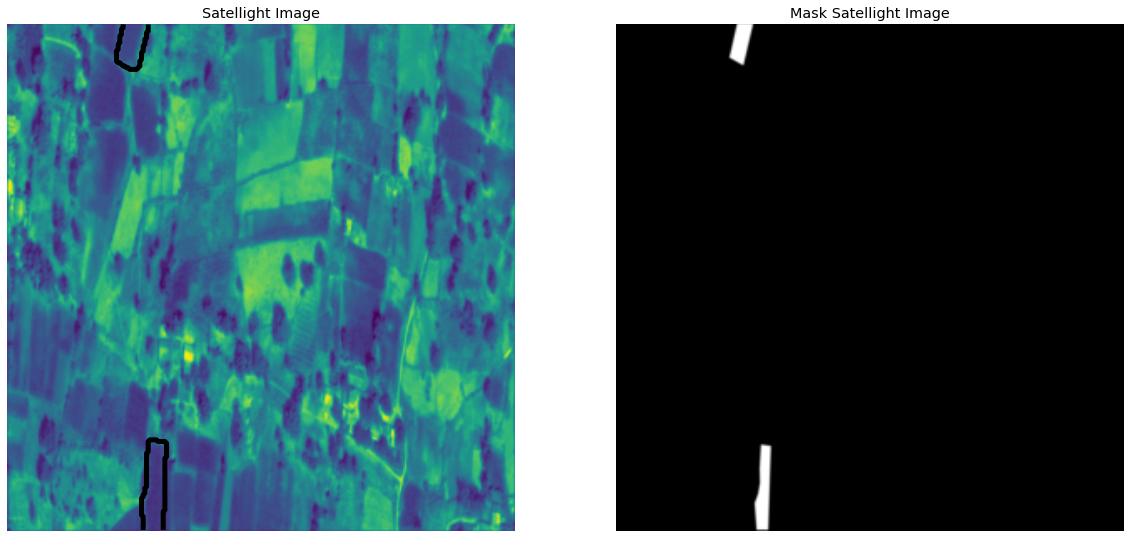

In [14]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [15]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [16]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [17]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [18]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

0

In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 304, 304, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 304, 304, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 304, 304, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 304, 304, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [26]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [27]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.9639 - auc: 0.6341 - sensitivity_at_specificity: 0.6587 - specificity_at_sensitivity: 0.6472
Epoch 00001: val_loss improved from inf to 10.70200, saving model to model-Unet.h5
9/9 [==============================] - 2s 187ms/step - loss: 0.2727 - accuracy: 0.9639 - auc: 0.6341 - sensitivity_at_specificity: 0.6587 - specificity_at_sensitivity: 0.6472 - val_loss: 10.7020 - val_accuracy: 0.1980 - val_auc: 0.2328 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.1485
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9646 - auc: 0.6675 - sensitivity_at_specificity: 0.7592 - specificity_at_sensitivity: 0.6699
Epoch 00002: val_loss improved from 10.70200 to 1.20785, saving model to model-Unet.h5
9/9 [==============================] - 2s 170ms/step - loss: 0.2528 - accuracy: 0.9646 - auc: 0.6675 - sensitivity_at_specificity: 0.7592 - specificit

In [28]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
3,0.219856,0.965098,0.731140,0.825129,0.754739,0.261002,0.953508,0.574453,0.659106,0.586061,0.001
2,0.235471,0.964778,0.688850,0.737497,0.724640,0.831530,0.721559,0.351369,0.262254,0.378238,0.001
4,0.207915,0.965072,0.713141,0.790173,0.771878,0.958692,0.654488,0.499126,0.500537,0.503120,0.001
1,0.252751,0.964639,0.667511,0.759196,0.669901,1.207850,0.642336,0.345716,0.316780,0.378837,0.001
0,0.272715,0.963881,0.634075,0.658672,0.647169,10.701997,0.197998,0.232798,0.000000,0.148538,0.001


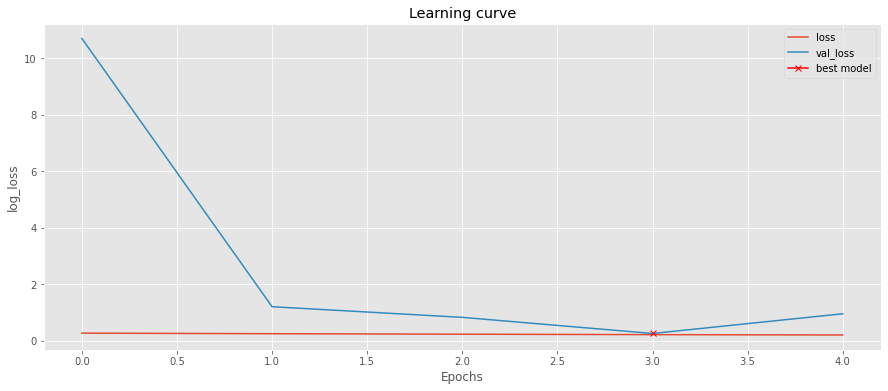

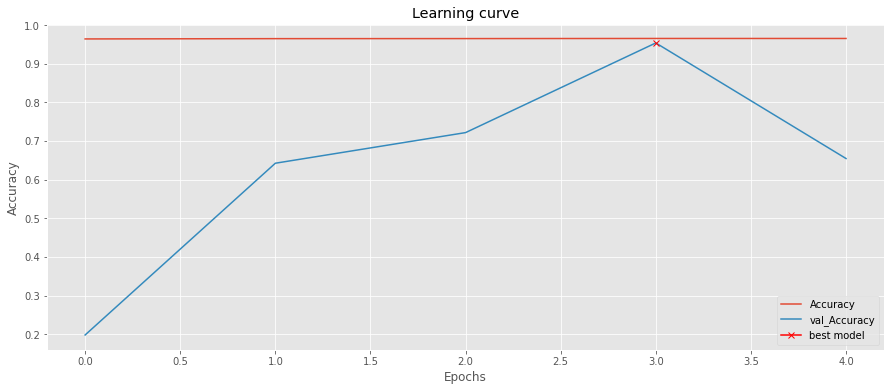

In [29]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [30]:
model.load_weights('model-Unet.h5')

In [31]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.2610 - accuracy: 0.9535 - auc: 0.5745 - sensitivity_at_specificity: 0.6591 - specificity_at_sensitivity: 0.5861


[0.2610020637512207,
 0.9535083770751953,
 0.5744533538818359,
 0.6591055393218994,
 0.5860614776611328]

In [32]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 16ms/step


In [33]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [34]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

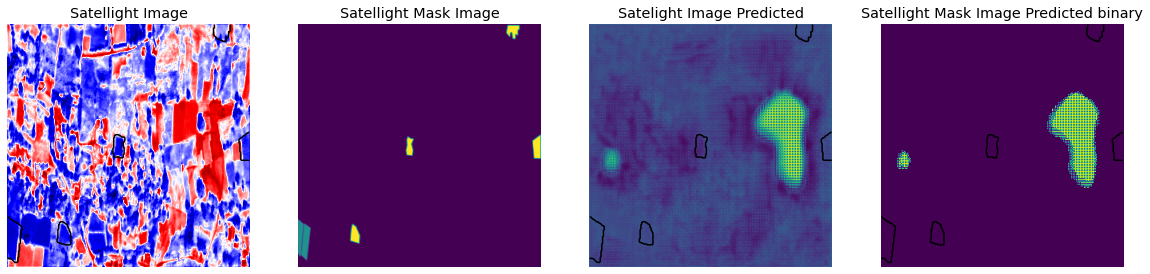

In [35]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

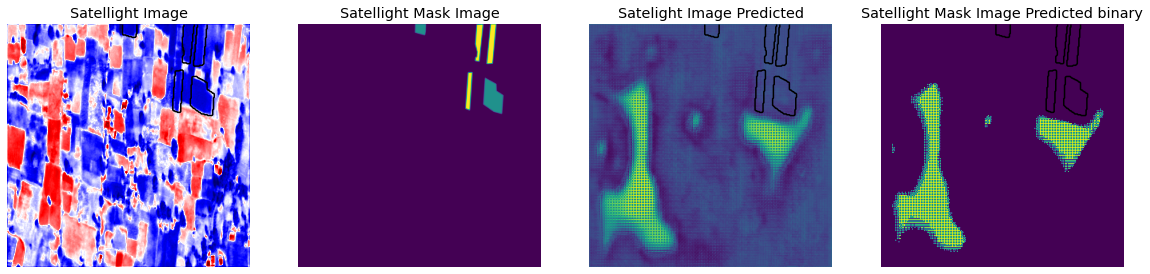

In [36]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

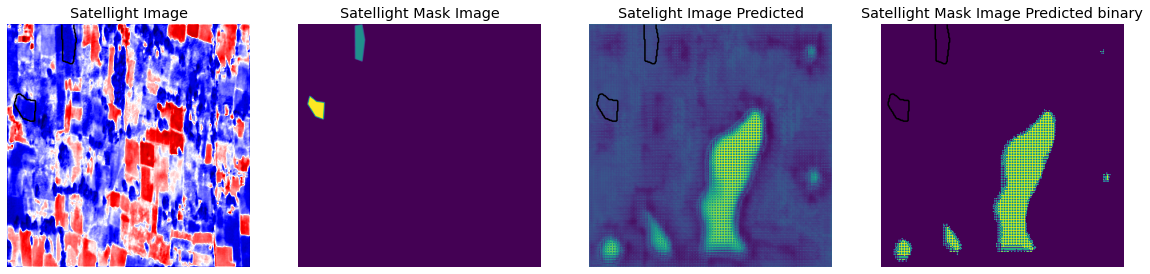

In [37]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

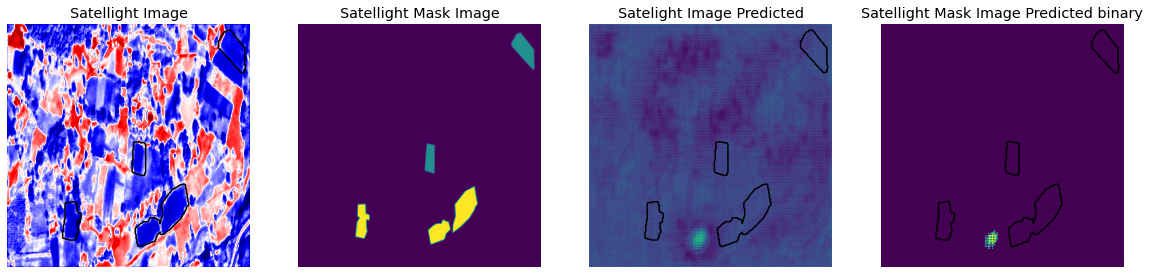

In [38]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

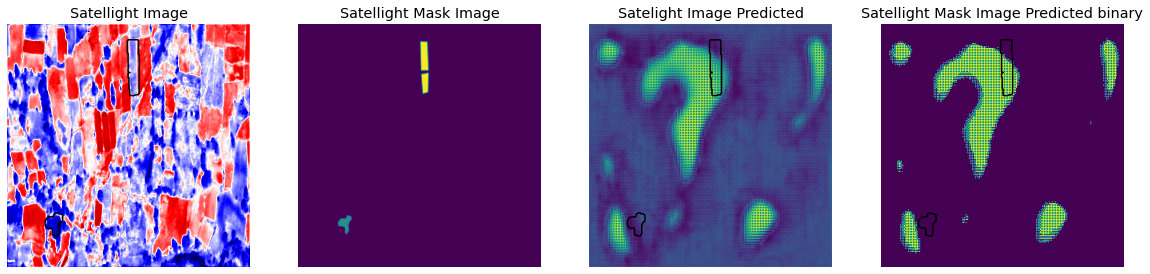

In [39]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

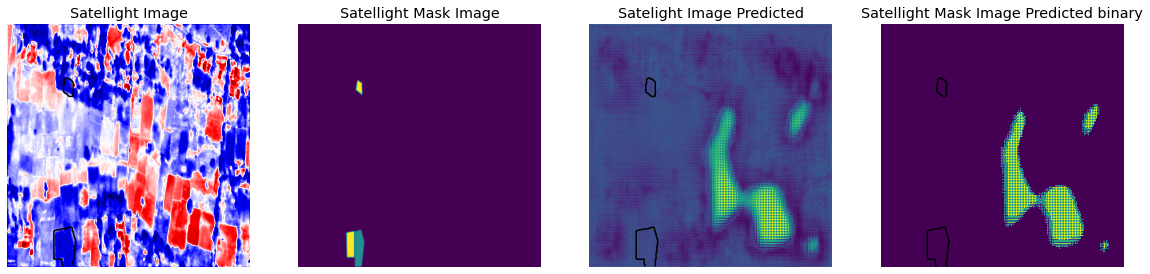

In [40]:
plot_sample(X_train, y_train, preds_train, preds_train_t)